# DialectGemma, finetune Gemma in order to talk with your grandpa!

### Project Objectives
The primary objective of this project is to enable the translation of dialects into their corresponding "base" languages by designing a streamlined and efficient data processing pipeline. This pipeline leverages techniques such as lemmatization and contextual similarity analysis to preprocess dialect datasets, thereby enhancing the translation accuracy of language models.

### Methodology
1. **Input Transformation**:
   - Dialectal input text, which traditional language models may struggle to interpret, is first processed through a lemmatization step. This simplifies the text by reducing words to their base or canonical forms.
   
2. **Translation via Language Model**:
   - The preprocessed text is then passed through a large language model (LLM). The LLM is tasked with translating the simplified text into the target base language, ensuring both syntactic and semantic accuracy.

### Key Advantages
- **Improved Comprehensibility**: By transforming dialectal input into a more standardized form, the system significantly enhances the LLM's ability to perform accurate translations.
- **Efficiency**: The use of lemmatization and contextual similarity minimizes the complexity of the input, reducing the computational load on the LLM.

This approach demonstrates a scalable and effective method for translating dialects, making the resulting system both practical and robust for real-world applications.


| Criteria | Compliant |
|---|---|
| **Compliant:** The submission was consistent with the guidelines and instructions. | [**yes**] |
| **Topical:** The submission was relevant to the prize categories. | [**yes**] |
| **Open:** The notebook and all of the underlying data sources were made public. The trained model has been published to the Kaggle Model Hub and contains supporting documentation. | [**yes**] |
| **Language:** The language selected is an eligible language listed below. | [**yes**] |




In [1]:
# %pip install --upgrade --no-cache-dir pip wheel setuptools black isort jupyterlab-code-formatter jupyterthemes jupyterlab_darkside_theme nvitop
!pip install unidecode langdetect spacy 
!pip install pip3-autoremove
!pip-autoremove torch torchvision torchaudio -y
!pip install torch torchvision torchaudio xformers --index-url https://download.pytorch.org/whl/cu121
!pip install unsloth 'transformers==4.47.1'
%pip install --upgrade nltk

!python -m spacy download en_core_web_md
!python -m spacy download fr_core_news_md
!python -m spacy download de_core_news_md
!python -m spacy download it_core_news_md
!python -m spacy download pl_core_news_md
!python -m spacy download pt_core_news_md
!python -m spacy download es_core_news_md
print('Remember to restart the kernel!!')

In [2]:
import kagglehub
dialect_to_ita_eng_path = kagglehub.dataset_download('alessiosavi/dialect-to-ita-eng')

In [3]:
import gc
import gzip
import json
import os
import pickle
import random
import re
import string
from collections import defaultdict
from copy import copy
from glob import glob
from pprint import pprint
from typing import *

# langdetect is used to detect the most similar language of the dialect, by this way we can enhance the translation process
import langdetect
import matplotlib.pyplot as plt
import nltk.translate.bleu_score as bleu
import nltk.translate.gleu_score as gleu
import numpy as np
import pandas as pd
import requests
import seaborn as sns

# spacy is used to perform the lemmatization
import spacy
import torch
from datasets import Dataset, load_dataset
from IPython.display import Markdown
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.auto import tqdm
from transformers import TrainingArguments, pipeline
from trl import SFTTrainer

# Some dialect has phonetic symbols, with `unidecode` library we aim to clean these phonetics symbols
from unidecode import unidecode
from unsloth import FastLanguageModel, load_correct_tokenizer

# Set SpaCy to prioritize GPU usage for faster NLP operations if available
spacy.prefer_gpu()
tqdm.pandas()
# Set a fixed seed for reproducibility across experiments
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Define sequence length constraints for text processing tasks
max_seq_length = 1024
min_seq_length = 0

os.environ["HF_TOKEN"] = "hf_YOUR_HF_TOKEN"
# Define a function to collect garbage and free up GPU memory if available
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Cache the spacy language models
nlps: Dict[str, spacy.Language] = {}

# Compile a regex pattern to split text into sentences by detecting punctuation followed by whitespace or newline
batch_regex = re.compile(r"(?<=[.!?\n])\s+")
# Create a set of all standard punctuation characters for efficient lookup during text processing
punctuation_set = set(string.punctuation)
# We want to build a text dataset, sometimes wikipedia (especially for dialect) tends to have a list of dates.
# This regexp aims to find (and count) the numbers of 'date/numbers' in the text. We want to remove these examples.
number_regex = re.compile(r"\d*\.\d+|\d+", re.MULTILINE)

def _collect():
    x = 0
    for i in range(3):
        x += gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    return x

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [4]:
# Due to my memory limitation, I batch each wikipedia page in a set of fixed number of words.
#  The last sentence of the first batch is the first sentence of the next batch.
#  Example: 'This is an example sentence. This sentence has to be separated. This, because it's too much to be handled by my GPU!'
#  Output:
#   BATCH 1: 'This is an example sentence. This sentence has to be separated.'
#   BATCH 2: 'This sentence has to be separated. This, because it's too much to be handled by my GPU!'
# The idea here is to have "continuity" of the context.
def batch_text_with_overlap(text: str, max_words=256) -> List[str]:
    """Batches text into chunks with a maximum number of words, allowing overlap between batches.

    Args:
        text: The input text string.
        max_words: The maximum number of words per batch.

    Returns:
        :return:A list of string batches.
    """
    # Split the text into sentences using regex
    sentences = batch_regex.split(text)

    batches = []
    current_batch = []
    current_word_count = 0

    for i, sentence in enumerate(sentences):
        sentence_word_count = len(sentence.split())

        if current_word_count + sentence_word_count <= max_words:
            # Add sentence to current batch
            current_batch.append(sentence)
            current_word_count += sentence_word_count
        else:
            # The current batch is ready, add it to batches
            if current_batch:
                batches.append(" ".join(current_batch).strip())
                # Start a new batch, including the last sentence of the previous batch
                current_batch = [sentence]
                current_word_count = sentence_word_count
                # Overlap: add the last sentence of the previous batch to the new batch
                if i > 0:
                    current_batch.insert(0, sentences[i - 1])
                    current_word_count += len(sentences[i - 1].split())
            else:
                # Handle cases where a single sentence is longer than max_words
                batches.append(sentence.strip())
                current_batch = []
                current_word_count = 0

    # Add the last batch if it's not empty
    if current_batch:
        batches.append(" ".join(current_batch).strip())
    return batches


def find_outliers(data, n=2):
    """
    Identifies outliers in a given Pandas Series based on the Z-score.
    This method leverages Z-score to clean "dirty" entries.

       Args:
           :param data: A Pandas Series containing numerical data.
           :param n: The number of standard deviations to use as a threshold for outlier detection.

       Returns:
          :return: A boolean Pandas Series where True indicates an outlier and False indicates a non-outlier.
    """
    mean = data.mean()
    std = data.std()
    data_zscore = (data - mean) / std

    # Identify outliers (e.g., |Z| > 3)
    mask = abs(data_zscore) > n
    return mask


def count_punctuation_and_numbers(text: str):
    """
    Counts the number of punctuation marks, numbers, and newline characters in a given string.
    This method is used in combination with `find_outliers` to clean "dirty" entries.

       Args:
           :param text: The input string.

       Returns:
           :return: A dictionary containing the counts of punctuation marks, numbers, and newline characters, or a dictionary with zero counts if the input string is empty.
    """
    if not text or len(text) == 0:
        return {"puncts": 0, "numbers": 0, "new_lines": 0}

    punct_count = sum(1 for char in text if char in punctuation_set)
    number_count = len(number_regex.findall(text))
    new_lines = text.count("\n")

    return {"puncts": punct_count, "numbers": number_count, "new_lines": new_lines}


def translate(text, target_language="Italian", model="meta-llama-3.1-70B-bnb-4bit"):
    """
    This method translates a given text into its corresponding language model.
    I've used a local cluster, using `unsloth/Meta-Llama-3.1-70B-bnb-4bit`.
    The model servers exposes a JSON over HTTP API that follows the [OpenAI spec](https://platform.openai.com/docs/api-reference/chat).
    This code is omitted cause is only infra-related stuff
    Args:
        :param text: The text to be translated.
        :param target_language: The language name of the target language.
        :param model: The LLM to use.
    Return:
        :return: Translated text.
    """
    url = "YOUR_CLUSTER_URL"
    prompt = f"You are a translator that don't add any sentences that are not written in the input text. Don't add also any comments, just translate the text into plain {target_language}."
    messages = [
        {
            "role": "system",
            "content": prompt,
        },
        {
            "role": "user",
            "content": text,
        },
    ]

    resp = requests.post(
        url,
        stream=False,
        timeout=(30, 300),
        json={
            "model": "local",
            "messages": messages,
            "stream": False,
        },
        headers={"x-service-id": model},
    )
    resp.raise_for_status()
    return resp


def translate_local(
    text, target_language="it", model_name="Helsinki-NLP/opus-mt-fr-en"
):
    """
    Translates text from one language to another using a specified LLM.
    NOTE: This method is not tested, is saved as reference in order to play/debug the solution without having a local GPU cluster

    Args:
        :param text: The text to be translated.
        :param target_language: The target language code (e.g., "en" for English, "fr" for French, "es" for Spanish).
        :param model_name: The name of the translation model from the Hugging Face Model Hub.

    Returns:
        :return: The translated text, or None if an error occurs.
    """
    try:
        translator = pipeline("translation", model=model_name)
        translated_text = translator(text, target_lang=target_language)[0][
            "translation_text"
        ]
        return translated_text
    except Exception as e:
        print(f"An error occurred during translation: {e}")
        return None


def clean_dataset(dataset: Dict[str, List[str]], n: int = 2) -> Dict[str, List[str]]:
    """
    Cleans a dataset by removing entries that are outliers based on punctuation and number counts.

    Args:
        :param: dataset: A dictionary where keys are identifiers and values are lists of strings.
        :param: n: The number of standard deviations to use as a threshold for outlier detection.

    Returns:
        :return: A new dictionary containing only the entries that are not considered outliers.
    """
    puncts = {}
    for k, v in dataset.items():
        puncts[k] = count_punctuation_and_numbers("\n".join(v))
    puncts = pd.DataFrame(puncts).T.reset_index()
    mask1 = find_outliers(puncts["puncts"], n=n)
    mask2 = find_outliers(puncts["numbers"], n=n)
    mask = mask1 | mask2
    keys = set(puncts[mask]["index"].to_list())
    return {k: v for k, v in dataset.items() if k not in keys}


def remove_content_by_target(d: Dict[str, List[str]], targets: List[str], lower=True):
    """Removes content from a dictionary based on the presence of specified target strings.

    Args:
        :param: d: A dictionary where keys are identifiers and values are lists of strings.
        :param: targets: A list of target strings to search for within the content.
        :param: lower: A boolean indicating whether to convert the content to lowercase before searching for targets.

    Returns:
        :return: A new dictionary containing only the content that does not contain any of the target strings.
    """
    data = defaultdict(list)
    for k, vs in d.items():
        for v in vs:
            _v = copy(v)
            if lower:
                _v = _v.lower()
            if not any(target in _v for target in targets):
                data[k].append(v)
    return data


def find_topic_by_target(d: Dict[str, List[str]], targets: List[str], lower=True):
    """Return the entries from a dictionary based on the presence of specified target strings.

    Args:
        :param: d: A dictionary where keys are identifiers and values are lists of strings.
        :param: targets: A list of target strings to search for within the content.
        :param: lower: A boolean indicating whether to convert the content to lowercase before searching for targets.

    Returns:
        :return: The keys of the input dictionary that contains any of the target strings.
    """
    keys = []
    for k, vs in d.items():
        text = "\n".join(vs)
        if lower:
            text = text.lower()
        if any(target in text for target in targets):
            keys.append(k)
    return keys


def remove_similar_documents(df, text_column, similarity_threshold=0.2):
    """Removes similar documents from a DataFrame based on TF-IDF and cosine similarity.

    Args:
        :param: df: The input Pandas DataFrame.
        :param: text_column: The name of the column containing the text data.
        :param: similarity_threshold: The threshold above which two documents are considered similar.

    Returns:
        :return: A new Pandas DataFrame with similar documents removed. Returns the original DataFrame if it's empty.
    """
    if df.empty:
        return df

    # 1. TF-IDF Vectorization
    vectorizer = TfidfVectorizer(ngram_range=(2, 3))
    tfidf_matrix = vectorizer.fit_transform(df[text_column])

    # 2. Cosine Similarity Calculation
    similarity_matrix = cosine_similarity(tfidf_matrix)

    # 3. Identify Documents to Remove
    to_remove = set()
    num_docs = len(df)
    for i in range(num_docs):
        for j in range(i + 1, num_docs):
            if similarity_matrix[i, j] > similarity_threshold:
                # Prioritize keeping the earlier document encountered in the DataFrame
                to_remove.add(j)

    # 4. Create a new DataFrame
    indices_to_keep = list(set(range(num_docs)) - to_remove)
    filtered_df = df.iloc[list(indices_to_keep)].copy()
    duplicated_df = df.iloc[list(to_remove)]

    return filtered_df, duplicated_df


## Chapter 1: Raw Dataset Creation

### Objective
The goal of this chapter is to prepare and clean raw text datasets to build a robust foundation for translation and lemmatization. However, to execute this notebook, **it is not necessary to run the (_commented_) translation step**, as the translated datasets are already available in a preprocessed format.  

### Process Overview
1. **Dataset Loading**: Text data is sourced from Wikipedia datasets using the `datasets` library.
2. **Filtering**: Entries are cleaned to remove noisy elements such as excessive punctuation, numbers, and unwanted formatting (e.g., `{{ }}`, `[[ ]]`).
3. **Batching**: Texts are divided into overlapping batches of fixed word lengths to maintain contextual continuity.
4. **Outlier Removal**: Entries with abnormal counts of punctuation or numbers are filtered out to ensure data quality.

### Infrastructure and Methods
- **Local Cluster**: For this project, translations were performed on a local cluster using the `LLaMA 3.1 70B` model in a 4-bit quantized format. This setup provides high-quality translations at scale.
- **Alternative Method**: To enable end-users to perform translations, a fallback implementation was developed. This method leverages pre-trained Hugging Face models, such as `Helsinki-NLP/opus-mt`, through the `transformers` pipeline. This approach ensures flexibility and accessibility for users without high-end infrastructure.

**_The translated datasets are stored in the Kaggle dataset repository `alessiosavi/dialect-to-ita-eng`, allowing immediate access for further stages of the project without rerunning this phase._**


In [5]:
def load_raw_data(language: str, keys: Union[List[str], None] = None):
    """Loads raw Wikipedia data for a given language, applying filtering and preprocessing.

    Args:
        :param: language: The language code (e.g., "en", "it").
        :param: keys: An optional list of titles to filter the dataset. If None, all titles are used.

    Returns:
        :return: A dictionary where keys are titles and values are lists of text batches (with overlap).
    """
    # Load dataset
    df = load_dataset("wikimedia/wikipedia", f"20231101.{language}", num_proc=6)[
        "train"
    ].to_pandas()
    if keys is not None:
        df = df[df["title"].isin(keys)]
    df["size"] = df["text"].apply(lambda x: len(x.split()))
    # Impose some limit on the dataset in order to reduce the global size of text data
    df = df[(df["size"] >= 128) & (df["size"] <= 1500)]
    df["text"] = df["text"].str.strip()
    mask1 = df["text"].str.contains("{{", regex=False) | df["text"].str.contains("}}", regex=False)
    mask2 = df["text"].str.contains("[[", regex=False) | df["text"].str.contains("]]", regex=False)
    mask3 = df["text"].str.contains("{|", regex=False) | df["text"].str.contains("|}", regex=False)
    df = df[~(mask1 | mask2 | mask3)].sample(frac=1, random_state=seed)
    ds_overlap = defaultdict(list)
    df[["title", "text"]].apply(
        lambda x: ds_overlap[x["title"]].extend(batch_text_with_overlap(x["text"])),
        axis=1,
    )
    assert len(ds_overlap.keys()) == len(df)

    ds_overlap = clean_dataset(ds_overlap, 2)
    print(f"Len after removing puncts/numbers: {len(ds_overlap)}")
    return ds_overlap

# Load the raw dataset from Wikipedia, `ia` is the dataset for `interlingua`
ds_overlap = load_raw_data(language="ia")
# Example of input data
for k,v in ds_overlap.items():
    print(k,v)
    break

Len after removing puncts/numbers: 3033
Bibliotheca National de Taiwan ["Le Bibliotheca National de Taiwan es le plus vetule bibliotheca public in Taiwan. Fundate in 1914, le bibliotheca es le loco de un grande collection de documentos super le historia, cultura, politica e geographia de Taiwan. Historia \nLe bibliotheca esseva fundate in 1914 durante le periodo de colonisation japonese como le Imperial Bibliotheca de Taiwan (台湾總督府図書館, Taiwan satoshi toku fu toshokan) sub le ordine de governator Sakuma Samata. Le prime permanente loco del bibliotheca esseva in Via Bo'ai (博愛路) in Taipei ma esseva destruite in un incursion de bombardamento american durante le Secunde Guerra Mundial. Post que le nationalistas (le Kuomintang) prendeva controlo del insula post le defaite de Japon, le bibliotheca esseva donate le nomine Bibliotheca Provincial de Taiwan (臺灣省圖書館, Táiwān-Shěng Túshūguǎn) e esseva movite provisorimente. In 1947 illo recipeva un nove nomine, le Bibliotheca Provincial de Taipei in

## Chapter 2: Preprocessing and Lemmatization

### Objective
Enhance the quality of raw text by cleaning, lemmatizing, and detecting the most similar language. This phase is crucial for ensuring accurate translation from a language that is not yet managed by any LLMs.

### Key Steps
- **Language Detection**: Using the `langdetect` library to determine the dialect’s closest base language.
- **Phonetic Cleaning**: Stripping away phonetic symbols using the `unidecode` library.
- **Lemmatization**: Utilizing SpaCy language models specific to the detected language to convert words to their base forms.

In [6]:
def detect_language(text: str) -> str | None:
    """
    Args:
        :param text: Input text language
    Returns:
        :return: 2-digit of the language code (e.g., "en" for English)
    """
    try:
        lang = langdetect.detect(text)
        return lang
    except Exception as e:
        print(f"Error detecting language: {e}")
        return None


def preprocess_text(text: str, nlp: spacy.Language):
    """
    Preprocesses text using a given SpaCy NLP model for lemmatization.

    Args:
        :param: text: The input text string.
        :param: nlp: The SpaCy NLP model to use for processing.

    Returns:
        :return: The lemmatized text string. Returns the original text if an error occurs during preprocessing.
    """
    try:
        doc = nlp(text)
        return " ".join([token.lemma_ for token in doc]).strip()
    except Exception as e:
        print(f"Error in preprocessing: {e}")
        return text  # Return the original text if preprocessing fails


def lemmatize_data(text: str, force_language: str | None = None) -> str:
    """
     Lemmatizes the input text using SpaCy, handling language detection and model loading.

    Args:
        :param: text: The input text string.
        :param: force_language: An optional language code to force lemmatization in a specific language. If None, the language is detected automatically.

    Returns:
        :return: The lemmatized text string (or an exception if `langdetext` is not able to understand the language code).
    """
    decoded_text = unidecode(text)
    language: str = (
        detect_language(decoded_text) if not force_language else force_language
    )
    if language in nlps:
        nlp = nlps[language]
    else:
        if language.startswith("en"):
            nlp = spacy.load(f"{language}_core_web_md")
        else:
            nlp = spacy.load(f"{language}_core_news_md")
        nlps[language] = nlp
    return preprocess_text(decoded_text, nlp)

In [7]:
# Here is an example of the lemmatization process, leveraging the straightforward pipeline above
for vs in ds_overlap.values():
    for v in vs:
        print("Before\n", v, "\n", "---" * 30)
        print("After\n", lemmatize_data(v), "\n", "---" * 30)
    break

Before
 Le Bibliotheca National de Taiwan es le plus vetule bibliotheca public in Taiwan. Fundate in 1914, le bibliotheca es le loco de un grande collection de documentos super le historia, cultura, politica e geographia de Taiwan. Historia 
Le bibliotheca esseva fundate in 1914 durante le periodo de colonisation japonese como le Imperial Bibliotheca de Taiwan (台湾總督府図書館, Taiwan satoshi toku fu toshokan) sub le ordine de governator Sakuma Samata. Le prime permanente loco del bibliotheca esseva in Via Bo'ai (博愛路) in Taipei ma esseva destruite in un incursion de bombardamento american durante le Secunde Guerra Mundial. Post que le nationalistas (le Kuomintang) prendeva controlo del insula post le defaite de Japon, le bibliotheca esseva donate le nomine Bibliotheca Provincial de Taiwan (臺灣省圖書館, Táiwān-Shěng Túshūguǎn) e esseva movite provisorimente. In 1947 illo recipeva un nove nomine, le Bibliotheca Provincial de Taipei in Taiwan (臺灣省立臺北圖書館, Táiwān Shěnglì Táiběi Túshūguǎn) e sub iste no

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


After
 il Bibliotheca National de Taiwan es lo plus vetule bibliotheca public in Taiwan . Fundate in 1914 , il bibliotheca es le loco di uno grande collection de documentos super il historia , cultura , politico e geographia de Taiwan . Historia 
 il bibliotheca essere fundare in 1914 durante il periodo de colonisation Japonese Como il Imperial Bibliotheca de Taiwan ( Tai Wan Zong Du Fu Tu Shu Guan , Taiwan satoshi toku essere toshokan ) sub il ordine de governator Sakuma Samata . il primo permanente loco di il bibliotheca essere in Via Bo' a il ( Bo Ai Lu ) in Taipei ma essere destruite in uno incursion de bombardamento american durante il Secunde guerra Mundial . Post que il nationalistas ( il Kuomintang ) prendere controlo di il insula post il defaita de Japon , il bibliotheca essere donare il nomina Bibliotheca Provincial de Taiwan ( Tai Wan Sheng Tu Shu Guan , Taiwan-Sheng Tushuguan ) e essere movire provisorimente . in 1947 illo recipere uno nove nomina , il Bibliotheca provincia

# Chapter 3: Translation Phase

This chapter focuses on the code responsible for translating dialectal text into a base language (like Italian or English).

### Objective

The primary goal of this phase is to translate dialectal text into a standard base language (e.g., Italian or English) using pre-trained and fine-tuned language models.

### Implementation Philosophy

The provided code emphasizes user adaptability and avoids unnecessary data processing. 

* **Flexibility:** The scripts are designed to be easily modified for users with different datasets and language pairs. They act as a base for customization rather than a rigid pipeline.
* **Leveraging Existing Translations:** The project already possesses datasets translated into Italian and English for various dialects. The code prioritizes utilizing these existing translations to minimize redundancy.
* **Local Development Focus:** This step is intended for local development and experimentation. The translated datasets are already available publicly, eliminating the need to rerun this phase unless specific customizations are necessary.

### Code Breakdown

1. **Avoiding Redundant Translation (Conditional Loading):**

The provided code snippet showcases a technique to prevent unnecessary translation of data that has already been processed. It checks for a global variable `ds_overlap_translated` which is assumed to be a dictionary storing previously translated data. If the variable doesn't exist, the code initializes it and attempts to load the latest saved version of the translated data from disk (using `glob` and `json.load`). This way, the script avoids re-translating data that has already been handled.

2. **Iterating Through Overlap Data (Translation Loop):**

Assuming there's no pre-existing translated data, or if new data needs processing, the code iterates through a dataset (`ds_overlap`) containing the dialectal text. It uses `tqdm` to display progress bars for both the overall loop and individual topics within the dataset.

* **Skipping Translated Topics:**

For each topic (key) in the dataset, the code first checks if it exists in the `ds_overlap_translated` dictionary. If it does, and the number of entries in both datasets is equal, it signifies that all entries for this topic have already been translated. In such cases, the script skips processing this topic entirely to avoid redundant translations.

* **Translating Individual Entries:**

If a topic requires translation, the code iterates through each entry (value) within that topic. It performs the following steps:

1. **Lemmatization (Optional):**  A function called `lemmatize_data` is used to potentially lemmatize the dialectal text (convert words to their base form). This step may be necessary depending on the chosen translation model and desired outcome.
2. **Translation:** A function called `translate` is used to translate the (optionally) lemmatized text. The specific implementation of this function depends on how the translation model is integrated and accessed.
3. **Extracting Translated Text and Cleaning:**

    * The translation response is assumed to be in JSON format. The script extracts the actual translated text from the response and removes any unnecessary prefix or extra whitespace related to the specific model used (e.g., "assistant" prefix added by the LLAMA model).
4. **Storing Translated Text:** The cleaned, translated text is appended to the corresponding topic list within the `ds_overlap_translated` dictionary.

* **Error Handling:**

The code includes basic error handling using a `try-except` block. If an exception occurs during translation for a specific entry (index), it logs the error message and the problematic index within the topic. However, it also deletes the entire topic from the `ds_overlap_translated` dictionary to prevent issues with potentially corrupted data for that topic.

* **Periodic Saving:**

Every five iterations (corresponding to translating five entries), the script saves the current state of the `ds_overlap_translated` dictionary to a gzipped JSON file on disk. This allows for resuming the translation process from the latest checkpoint in case of interruptions or errors.

* **Final Saving:**

Finally, after processing all topics and entries, the script saves the final version of the `ds_overlap_translated` dictionary containing all translated text to a separate JSON file.

In summary, this code provides a flexible framework for translating dialectal text using a pre-trained model. It prioritizes utilizing existing translations, avoids redundancy, and allows for easy customization and error handling.  
**_However, it's important to note that this code is intended for local development and experimentation. The translated datasets are already available publicly, so this script might not be necessary for production use._**

In [8]:
# # Dirty hack to avoid losing the already translated dataset.
# if "ds_overlap_translated" not in globals():
#     ds_overlap_translated = defaultdict(list)
#     # Load the latest file saved, instead of restart from 0
#     files = glob(f"{dialect_to_ita_eng_path}/ds_overlap_translated_ia_lemma_it*")
#     if len(files) > 0:
#         files.sort(key=lambda x: os.path.getmtime(x))
#         ds_overlap_translated = defaultdict(list, json.load(gzip.open(files[-1])))

In [9]:
# print(f"Len of already translated data: {len(ds_overlap_translated)}")
# n = 0
# for k, vs in tqdm(ds_overlap.items(), total=len(ds_overlap), position=0):
#     # Avoid translating the already managed topics
#     if k in ds_overlap_translated and len(vs) == len(ds_overlap_translated[k]):
#         continue
#     for idx, v in enumerate(tqdm(vs, leave=False, position=1, desc=k)):
#         if (idx + 1) <= len(ds_overlap_translated[k]):
#             continue
#         try:
#             lemmatized_v = lemmatize_data(v)
#             res = translate(lemmatized_v)
#             response = (
#                 res.json()["choices"][0]["message"]["content"]
#                 # This cleaning is related to the LLAMA model used.
#                 .removeprefix("<|start_header_id|>assistant<|end_header_id|>").strip()
#             )
#             ds_overlap_translated[k].append(response)
#         except Exception as e:
#             print(f"Missing idx: {idx} of {k} | Error: {e}")
#             del ds_overlap_translated[k]
#             break
#     n += 1
#     if n % 5 == 0:
#         # Save the dataset every 5 wikipedia webpages translated
#         fname = f"data/ds_overlap_translated_ia_lemma_it_{n}_{len(ds_overlap_translated)}.json"
#         with gzip.open(fname, "wt") as zipfile:
#             json.dump(ds_overlap_translated, zipfile)
# # Save the last version of the dataset
# json.dump(ds_overlap_translated, open("ds_overlap_translated_ia_lemma_it.json", "wt"))

# Chapter 4: Dataset Aggregation and Cleaning

This chapter focuses on the code responsible for preparing the raw and translated datasets into a format suitable for training a fine-tuned language model. 

### Objective

The primary objective of this code is to combine raw dialectal text with its corresponding translated text (e.g., Italian or English) into a structured format. This structured format ensures consistency and compatibility with the chosen language model.

### Key Features

The code incorporates several key functionalities to clean and prepare the dataset:

* **Aggregation:** It matches the original dialectal entries with their translated counterparts, ensuring that each data point has both the source and target language text associated with it.
* **Outlier Detection and Removal:**  The script identifies entries with unusual patterns in terms of:
    * Token length (number of words/sub-words after tokenization)
    * Punctuation ratio (percentage of punctuation characters)
    * Word count (number of words)
* **TF-IDF Similarity Check:**  This step aims to identify and remove duplicate or overly similar entries within the dataset. This helps to improve the model's training diversity by reducing redundancy.
* **Statistics and Visualization (Optional):**  The code might include functionalities to analyze various statistics of the dataset, such as token length distribution and word-to-token ratios. These statistics can be helpful for understanding the dataset characteristics and identifying potential issues.


### Code Breakdown

1. **Dataset Configuration (Commented Out):**

The code snippet starts with commented-out sections that showcase a template configuration (`dataset_config`). This allows for easy switching between different languages by specifying:

* `starting_language`: The source dialectal language (e.g., Sicilian, Neapolitan).
* `wikilanguage`: The corresponding Wikipedia language code (used for potential filtering).
* Paths to the translated datasets in Italian (`italian`) and English (`english`).

2. **Loading Translated Data:**

The code loads the translated datasets for both Italian (`ds_overlap_it`) and English (`ds_overlap_en`) from their respective JSON files using the `json.load` function.

3. **`aggregate_dataset` Function:**

This function takes two dictionaries as input:

* `raw_base`: Dictionary containing the raw dialectal text (topics as keys, lists of strings as values).
* `raw_translated`: Dictionary containing the translated text (topics as keys, lists of strings as values).

The function iterates through each topic in the translated dataset (`raw_translated`). For each topic, it retrieves the corresponding list of raw dialectal text (`base_data`) and the translated sentences (`translated_data`). Then, it creates a list of inner dictionaries, where each inner dictionary contains a key-value pair:

* `original`: The raw dialectal sentence for this data point.
* `translated`: The corresponding translated sentence (Italian or English).

Finally, the function adds this list of inner dictionaries (representing the data points for a specific topic) to the main dictionary (`ds`) with the topic name as the key. This results in a structured dictionary where each key is a topic and the corresponding value is a list of dictionaries containing both the original and translated text for each data point within that topic.

4. **`filter_dataset` Function:**

This function performs cleaning and filtering on a translated dataset:

* `language`: The dialect language of the dataset (e.g., Sicilian).
* `ds_translated`: The translated dataset dictionary.
* `n` (optional): A threshold for outlier removal (data points with extreme token length, punctuation ratio, or word count).
* `ds_base` (optional): The raw dialectal text dataset (used for consistency checks).

* **Handling Missing Raw Data:**

   - If the `ds_base` parameter is not provided, the function calls the  `load_raw_data` function to retrieve the raw dialectal text for the specified topics.

* **Matching Topics:**

   - The function identifies common topics that exist in both the translated and raw datasets. This ensures that data points with translations are matched with their corresponding raw counterparts.

* **Filtering Based on Content:**

   - The code (commented out) suggests removing entries containing specific patterns like `{|`, `|}`, suggesting potential Wikipedia-related content that might be noisy for the training data.

* **Outlier Removal Based on Punctuation and Word Count:**

   - The `clean_dataset` function is used to remove entries with high numbers of punctuation characters or unusual word counts. This helps to improve data quality and prevent the model from learning from potentially noisy examples.

* **Final Cleaning and Assertions:**

   - The function performs final cleaning on both the raw and translated datasets using the `

In [10]:
# Load the dataset
# Here we have the template configuration in order to play with different (already managed languages)

# dataset_config = {
#     "starting_language": "sicilian",
#     "wikilanguage": 'scn',

#     "italian": f"{dialect_to_ita_eng_path}/ds_overlap_translated_scn_lemma_it.json",
#     "english": f"{dialect_to_ita_eng_path}/ds_overlap_translated_scn_lemma_en.json"
# }

# dataset_config = {
#     "starting_language": "napolitan",
#     "wikilanguage": 'nap',

#     "italian": f"{dialect_to_ita_eng_path}/ds_overlap_translated_nap_lemma_it.json",
#     "english": f"{dialect_to_ita_eng_path}/ds_overlap_translated_nap_lemma_en.json"
# }


# dataset_config = {
#     "starting_language": "venetian",
#     "wikilanguage": 'vec',

#     "italian": f"{dialect_to_ita_eng_path}/ds_overlap_translated_vec_lemma_it.json",
#     "english": f"{dialect_to_ita_eng_path}/ds_overlap_translated_vec_lemma_en.json"
# }

dataset_config = {
    "starting_language": "interlingua",
    "wikilanguage": 'ia',

    "italian": f"{dialect_to_ita_eng_path}/ds_overlap_translated_ia_lemma_it.json",
    "english": f"{dialect_to_ita_eng_path}/ds_overlap_translated_ia_lemma_en.json"
}


it_fname = dataset_config["italian"]
en_fname = dataset_config["english"]
starting_language = dataset_config["starting_language"]
wikilanguage = dataset_config["wikilanguage"]
# NOTE: On your local env, the dataset will be gzipped (remember to change from plain `open` to `gzip.open`)
ds_overlap_it: Dict[str, List[str]] = json.load(open(it_fname))
ds_overlap_en: Dict[str, List[str]] = json.load(open(en_fname))

In [11]:
def aggregate_dataset(
    raw_base: Dict[str, List[str]], raw_translated: Dict[str, List[str]]
) -> Dict[str, List[Dict[str, List[str]]]]:
    """Aggregates two raw datasets (base and translated) into a single structured dataset.

    Args:
        :param: raw_base: A dictionary where keys are topics and values are lists of strings (base data).
        :param: raw_translated: A dictionary where keys are topics and values are lists of strings (translated data).

    Returns:
        :return: A dictionary where keys are topics and values are lists of dictionaries.
            Each inner dictionary contains the "original" and "translated" strings for a given data point.
    """
    ds = {}
    for topic in raw_translated:
        base_data = raw_base[topic]
        translated_data = raw_translated[topic]
        d = []
        for v1, v2 in zip(base_data, translated_data):
            d.append({"original": v1, "translated": v2})
        ds[topic] = d
    return ds


def filter_dataset(language, ds_translated, n=2, ds_base=None):
    """Filters and cleans a translated dataset based on a base dataset.

    Args:
        :param: language: The language of the dataset.
        :param: ds_translate: A dictionary representing the translated dataset (topic -> list of strings).
        :param: n: A threshold for outlier removal.
        :param: ds_base: An optional dictionary representing the base dataset (topic -> list of strings). If None, it's loaded using load_raw_data.

    Returns:
        :return: A tuple containing the filtered base dataset, the filtered translated dataset, and the aggregated dataset.
    """
    if ds_base is None:
        ds_base = load_raw_data(language, list(ds_translated.keys()))
    # Be sure that we are dealing only with the same topics.
    common_keys = set(ds_translated.keys()).intersection(ds_base.keys())

    # Due to the "batched" dataset (a big chunk of text is divided in multiple parts)
    #  we need to be sure that, for each topic, we have the same number of entries.
    common_keys = [k for k in common_keys if len(ds_base[k]) == len(ds_translated[k])]

    # Filtering both dataset and removing noisy topics
    raw_base = {k: ds_base[k] for k in common_keys}
    # Don't trust the dataset. Removing entries for which we have wikipedia-related noisy text
    raw_base = remove_content_by_target(raw_base, ["{|", "|}", "[[", "]]", "{{", "}}"])

    # Remove topics that contain a high number of numbers/punctuation.
    # By this way, we can have a more clean dataset
    raw_base = clean_dataset(raw_base, n)
    raw_translated = {k: ds_translated[k] for k in raw_base}
    raw_translated = clean_dataset(raw_translated, n)
    raw_base = {k: ds_base[k] for k in raw_translated}

    # Verify that we are dealing with the same topics
    assert raw_base.keys() == raw_translated.keys()
    # Verify that for each topic we have the same number of "separated batches"
    assert (
        sum(
            [
                abs(len(ia) - len(it))
                for ia, it in zip(raw_translated.values(), raw_base.values())
            ]
        )
        == 0
    )

    print(
        f"[{language}] Raw entries: {len(ds_translated)} | Clean entries: {len(raw_base)}"
    )
    return raw_base, raw_translated, aggregate_dataset(raw_base, raw_translated)


raw_base_en, raw_translated_en, ds_aggregated_en = filter_dataset(
    wikilanguage, ds_overlap_en
)
raw_base_it, raw_translated_it, ds_aggregated_it = filter_dataset(
    wikilanguage, ds_overlap_it
)
DATASET_TYPE_TRANSLATE = "translate"
DATASET_TYPE_DESCRIBE = "describe"
DATASET_TYPES = [DATASET_TYPE_TRANSLATE, DATASET_TYPE_DESCRIBE]
# We let the possibility to the final user to train against multiple languages
all_datasets = [
    {
        "starting_language": starting_language,
        "translated_language": "english",
        "dataset": ds_aggregated_en,
        "type": DATASET_TYPES,
    },
    {
        "starting_language": starting_language,
        "translated_language": "italian",
        "dataset": ds_aggregated_it,
        "type": DATASET_TYPES,
    },
]

Len after removing puncts/numbers: 2724
[ia] Raw entries: 3009 | Clean entries: 2201
Len after removing puncts/numbers: 2712
[ia] Raw entries: 3000 | Clean entries: 2229


# Chapter 5: Building a Clean Dataset for Fine-Tuning Gemma2

In this chapter, we outline the process of transforming raw data into a clean, structured dataset optimized for fine-tuning the Gemma2 model. The goal is to maximize the utility of the raw data by creating two distinct types of datasets:

- **Translation Dataset**: Focused on translating dialectal content into a comprehensible base language.
- **Description Dataset**: Designed to enable the model to generate descriptive content on specific topics in the dialect language.

### Final Objective
Our ultimate aim is to develop a model capable of:
1. Translating dialects into an intelligible base language with high accuracy.
2. Describing given topics directly in the dialect language, ensuring clarity and relevance.

In [12]:
instruction_translate = "Provide a punctual translation of the following text from {} to {}, without any comments, explanations or interpretations."
instruction_describe = "Describe the following topic in the following language: {}."

alpaca_prompt_template = """<start_of_turn>user
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

<end_of_turn>
<start_of_turn>model
### Response:
{}
<end_of_turn>"""
_collect()
display(Markdown('### Example of "translating task"'))
print(
    alpaca_prompt_template.format(
        instruction_translate.format("Italian", "English"), "INPUT", "OUTPUT"
    )
)
print("---" * 30)
display(Markdown('### Example of "describing task"'))
print(
    alpaca_prompt_template.format(
        instruction_describe.format("Italian"), "INPUT", "OUTPUT"
    )
)

### Example of "translating task"

<start_of_turn>user
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Provide a punctual translation of the following text from Italian to English, without any comments, explanations or interpretations.

### Input:
INPUT

<end_of_turn>
<start_of_turn>model
### Response:
OUTPUT
<end_of_turn>
------------------------------------------------------------------------------------------


### Example of "describing task"

<start_of_turn>user
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Describe the following topic in the following language: Italian.

### Input:
INPUT

<end_of_turn>
<start_of_turn>model
### Response:
OUTPUT
<end_of_turn>


# Chapter 5.1: Explaination of how the dataset is created
This script processes multiple datasets to prepare a training/test dataframe `ds` that facilitates two types of tasks:
1. **"Describe" Task**: Uses the original data to train a network to describe a given topic in its native language.
2. **"Translate" Task**: Leverages both original-to-translated and translated-to-original transformations to augment data and improve the model's translation capabilities.

The output is a deduplicated dataframe with prompts, which serves as input for training a model.

---

#### Key Components:

##### 1. **Dataset Configuration**:
Each dataset configuration (`dataset_conf`) contains the following:
- `starting_language`: The original language of the dataset.
- `translated_language`: The language into which the content has been translated.
- `dataset`: A dictionary with the structure `{topic: [{"original": ..., "translated": ...}]}`.
- `type`: A list specifying the task type(s), either `DATASET_TYPE_DESCRIBE` or `DATASET_TYPE_TRANSLATE`.

##### 2. **Data Preparation**:
The code processes datasets to create a dataframe (`tdf`) with columns:
- `topic`: The topic of the dataset entry.
- `original_content`: Content in the original language.
- `translated_content`: Content in the translated language.

##### 3. **Data Augmentation for Tasks**:
- **Describe Task**: 
  - Prompts are generated to describe the topic in the native (starting) language.
  - Columns include: `prompt`, `starting_language`, `translated_language`, and `task_type`.

- **Translate Task**:
  - Prompts for translating both original-to-translated and translated-to-original.
  - Columns include: `prompt`, `starting_language`, `translated_language`, `task_type`, and content fields.

##### 4. **Deduplication**:
To avoid duplicate topics with similar prompts in different languages, duplicates in the `prompt` column are removed.
This is necessary due to the `describe` dataset that can have duplicates by definition for multiple languages.

##### 5. **Model Tokenizer**:
A tokenizer is loaded using the `load_correct_tokenizer` function, with a specified maximum sequence length and end-of-sequence token (`EOS_TOKEN`).

In [13]:
# Initialize an empty DataFrame to store all processed data.
ds = pd.DataFrame()

for dataset_conf in tqdm(all_datasets):
    # This loop iterates through all dataset configurations, extracting the starting and translated languages and the raw dataset.
    starting_language = dataset_conf["starting_language"]
    translated_language = dataset_conf["translated_language"]
    dataset = dataset_conf["dataset"]

    # Creating a dataframe from the given "raw" dataset.
    # The dataset will contain ["topic", "original_content", "translated_content"]
    raw_text = []
    _ = [
        [raw_text.append([k, v["original"], v["translated"]]) for v in vs]
        for k, vs in dataset.items()
    ]
    tdf = pd.DataFrame(raw_text)
    tdf.columns = ["topic", "original_content", "translated_content"]

    for dataset_type in dataset_conf["type"]:
        if dataset_type == DATASET_TYPE_DESCRIBE:
            _tdf = tdf.copy()
            # Using the original content (in native language of dataset)
            _tdf["prompt"] = _tdf.apply(
                lambda x: alpaca_prompt_template.format(
                    instruction_describe.format(starting_language),
                    x["topic"],
                    x["original_content"],
                ),
                axis=1,
            )
            _tdf["starting_language"] = translated_language
            _tdf["translated_language"] = starting_language
            _tdf["task_type"] = DATASET_TYPE_DESCRIBE
            ds = pd.concat([ds, _tdf])
        elif dataset_type == DATASET_TYPE_TRANSLATE:
            # I've simplified the code avoiding fancy method (this is memory inefficient). Also, I want the code to be "hackable" to be modified by the final user purpose.
            # Here I store the "original-to-translated" translation
            tdf1 = tdf.copy()
            # Here I store the "translated-to-original" translation
            tdf2 = tdf.copy()

            # Translate from ORIGINAL_LANGUAGE --> TRANSLATED_LANGUAGE
            tdf1["prompt"] = tdf1.apply(
                lambda x: alpaca_prompt_template.format(
                    instruction_translate.format(
                        starting_language, translated_language
                    ),
                    x["original_content"],
                    x["translated_content"],
                ),
                axis=1,
            )
            tdf1["starting_language"] = starting_language
            tdf1["translated_language"] = translated_language
            tdf1["task_type"] = DATASET_TYPE_TRANSLATE
            ds = pd.concat([ds, tdf1])

            # Translate from TRANSLATED_LANGUAGE --> ORIGINAL_LANGUAGE
            tdf2["prompt"] = tdf2.apply(
                lambda x: alpaca_prompt_template.format(
                    instruction_translate.format(
                        translated_language, starting_language
                    ),
                    x["translated_content"],
                    x["original_content"],
                ),
                axis=1,
            )
            tdf2["starting_language"] = translated_language
            tdf2["translated_language"] = starting_language
            original_content = tdf2.pop("original_content")
            translated_content = tdf2.pop("translated_content")
            tdf2["original_content"] = translated_content
            tdf2["translated_content"] = original_content
            tdf2["task_type"] = DATASET_TYPE_TRANSLATE
            ds = pd.concat([ds, tdf2])

# For the "describe" dataset, we are interested only in describing the topic in interlingua.
# By this way we remove the "similar prompt" in order to remove the duplicated topic between italian and english
df = ds.drop_duplicates("prompt").reset_index(drop=True).copy()
del ds
_collect()
model_id = "google/gemma-2-2b-it"

tokenizer = load_correct_tokenizer(model_id, max_seq_length)
EOS_TOKEN = tokenizer.eos_token

  0%|          | 0/2 [00:00<?, ?it/s]

In [14]:
df.groupby(['starting_language', 'translated_language', 'task_type']).size()

starting_language  translated_language  task_type
english            interlingua          describe     2974
                                        translate    2974
interlingua        english              translate    2974
                   italian              translate    3032
italian            interlingua          describe      148
                                        translate    3032
dtype: int64

# Chatper 6: Data Processing and Visualization

## Overview
This script performs several preprocessing steps on a dataset and visualizes the results:

1. Adds an end-of-sequence (EOS) token to each prompt.
2. Calculates metrics such as:
   - **New Lines Ratio**: Ratio of newline characters to words.
   - **Number of Tokens**: Number of tokens per prompt.
   - **Length Ratio**: Ratio of original to translated content lengths.
3. Applies filters to exclude outliers and entries outside a token range.
4. Visualizes the distribution of word counts, token counts, and ratios.

  0%|          | 0/15134 [00:00<?, ?it/s]

Removing 741 entries that are out of [1024 - 0] tokens. 14393 entries remaining.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


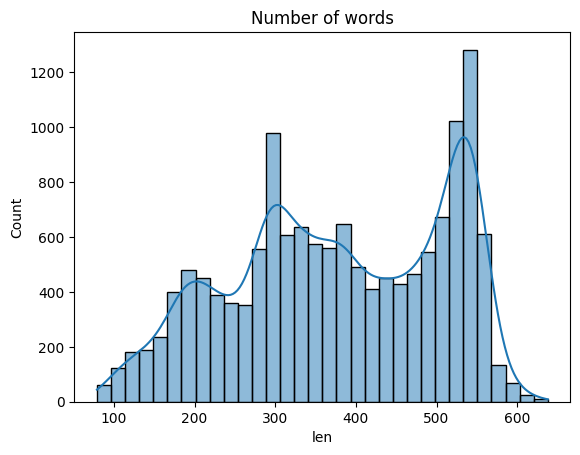

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


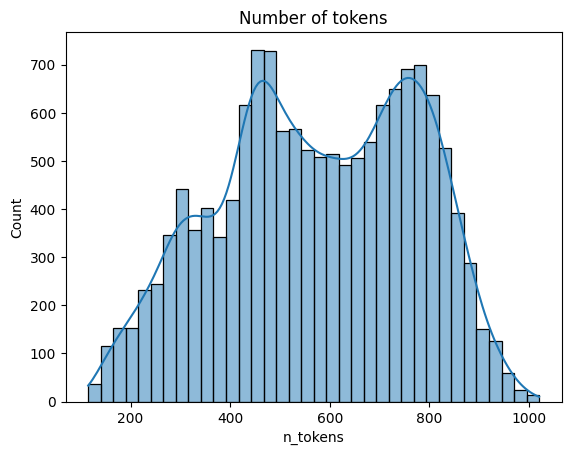

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


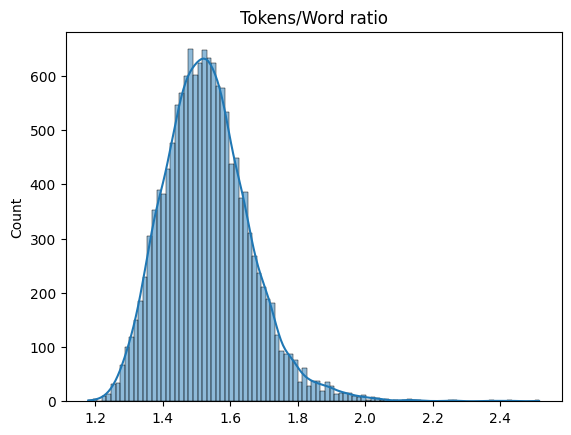

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


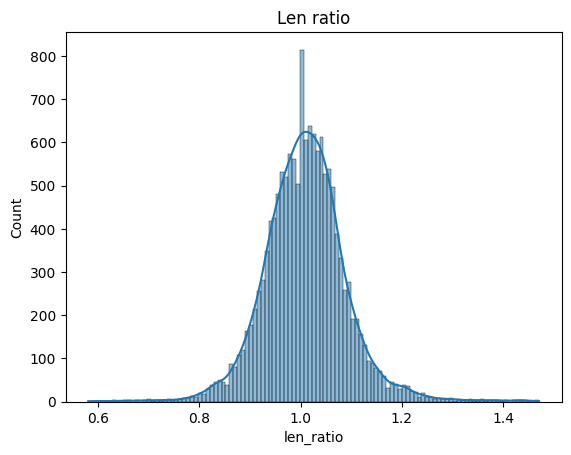

In [15]:
df["prompt"] = df["prompt"] + EOS_TOKEN
df["new_lines_ratio"] = df["prompt"].apply(lambda x: x.count("\n") / len(x.split()))
df["n_tokens"] = df["prompt"].progress_apply(lambda x: len(tokenizer.encode(x)))
df["len_ratio"] = df.apply(
    lambda x: len(x["original_content"].split()) / len(x["translated_content"].split()),
    axis=1,
)
mask_ratio = ~find_outliers(df["len_ratio"], n=1)
mask_len = (df["n_tokens"] >= min_seq_length) & (df["n_tokens"] <= max_seq_length)
mask_lines = ~find_outliers(df["new_lines_ratio"])
mask = mask_len & mask_lines & mask_ratio
df = df[mask].reset_index(drop=True)
df["len"] = df["prompt"].apply(lambda x: len(x.split()))

print(
    f"Removing {(~mask).sum()} entries that are out of [{max_seq_length} - {min_seq_length}] tokens. {len(df)} entries remaining."
)
sns.histplot(df["len"], kde=True).set(title="Number of words")
plt.show()
sns.histplot(df["n_tokens"], kde=True).set(title="Number of tokens")
plt.show()
sns.histplot(df["n_tokens"] / df["len"], kde=True).set(title="Tokens/Word ratio")
plt.show()
sns.histplot(df["len_ratio"], kde=True).set(title="Len ratio")
plt.show()

# Chapter 6.1: Creating the final dataest (train + test)
The test set is retrieved using the cosine similarity betwen the between TF-IDF vectors of the documents.
This is because I want to cover as many topics as possible, to let the network have the chance to generalize better.

## Document Similarity Filtering

This code snippet filters a Pandas DataFrame (`df`) to remove similar documents based on their content, while grouping by starting language, translated language, and task type. It uses a similarity threshold to identify and remove near-duplicate entries.

### Functionality

1. **Grouping:** The DataFrame is grouped by `starting_language`, `translated_language`, and `task_type`. This ensures that similarity checks are performed only within documents that share these attributes.

2. **Similarity Removal:** For each group, the `remove_similar_documents` function is called. This function takes the group's DataFrame and the column containing the document content (`original_content`) as input. It uses a `similarity_threshold` of 0.2 to determine which documents are considered similar. The function returns two DataFrames:
    - `new_df`: Contains the documents that are *not* considered similar.
    - `dups`: Contains the documents that *are* considered similar (duplicates).

3. **Concatenation and Logging:** The code then concatenates the `new_df` and `dups` DataFrames from each group into `filtered_df` and `duplicated_df`, respectively. It also prints a message indicating the number of entries removed for each group.

4. **Memory Management:** After processing all groups, the original `df` is deleted, and `filtered_df` is assigned to `df`. This is followed by deleting `filtered_df` and calling `gc.collect()` to free up memory. The DataFrame is also reset to avoid potential issues with the index.

5. **Duplicate Ratio Calculation:** The code calculates the percentage of removed documents (duplicates) relative to the final filtered DataFrame.

In [16]:
# Finding similar documents that share the same languages and task_type (translate, describe)
filtered_df = pd.DataFrame()
duplicated_df = pd.DataFrame()
for group_name, _df in df.groupby(
    ["starting_language", "translated_language", "task_type"]
):
    new_df, dups = remove_similar_documents(
        _df, "original_content", similarity_threshold=0.2
    )
    print(
        f'Removed {len(_df) - len(new_df)} entries for {dict(zip(["starting_language", "translated_language", "task_type"], list(group_name)))}'
    )
    filtered_df = pd.concat([filtered_df, new_df], ignore_index=True)
    duplicated_df = pd.concat([duplicated_df, dups], ignore_index=True)
del df
df = filtered_df.reset_index(drop=True).copy()
del filtered_df
gc.collect()
print(f'Test size ratio:{len(duplicated_df) / len(df) * 100}')
display(df.sample(2))
df[
    ["starting_language", "translated_language", "task_type"]
].value_counts().sort_index()

Removed 237 entries for {'starting_language': 'english', 'translated_language': 'interlingua', 'task_type': 'describe'}
Removed 134 entries for {'starting_language': 'english', 'translated_language': 'interlingua', 'task_type': 'translate'}
Removed 252 entries for {'starting_language': 'interlingua', 'translated_language': 'english', 'task_type': 'translate'}
Removed 264 entries for {'starting_language': 'interlingua', 'translated_language': 'italian', 'task_type': 'translate'}
Removed 14 entries for {'starting_language': 'italian', 'translated_language': 'interlingua', 'task_type': 'describe'}
Removed 124 entries for {'starting_language': 'italian', 'translated_language': 'interlingua', 'task_type': 'translate'}
Test size ratio:7.66756433273489


,topic,original_content,translated_content,prompt,starting_language,translated_language,task_type,new_lines_ratio,n_tokens,len_ratio,len
12822,Flamenco,Il flamenco è una forma d'arte che si concentr...,Le Flamenco es un forma de arte que es centrat...,<start_of_turn>user\nBelow is an instruction t...,italian,interlingua,translate,0.031026,609,1.050279,419
2232,Jano,Jano es le deo roman qui patronisava le comenc...,Janus is the Roman god who patronizes the begi...,<start_of_turn>user\nBelow is an instruction t...,english,interlingua,describe,0.051546,446,1.064655,291


starting_language  translated_language  task_type
english            interlingua          describe     2542
                                        translate    2718
interlingua        english              translate    2590
                   italian              translate    2629
italian            interlingua          describe      114
                                        translate    2775
Name: count, dtype: int64

# Chapter 6.2: Final Dataset Creation and Splitting

This code snippet creates training and testing datasets from the filtered DataFrame (`df`) and the duplicated DataFrame (`duplicated_df`), respectively. It then saves these datasets to disk in Hugging Face format.

### Functionality

1. **Grouped Prompt Display:** The code first iterates through the DataFrame `df`, grouped by `starting_language`, `translated_language`, and `task_type`. For each group, it prints the group's identifier and a sample prompt from that group. This provides a quick overview of the data within each group.

2. **Dataset Splitting:** The filtered DataFrame (`df`) is used to create the training dataset (`ds_train`), and the duplicated DataFrame (`duplicated_df`) is used to create the testing dataset (`ds_test`). Both datasets are shuffled using `sample(frac=1, random_state=seed)` to ensure randomness and reproducibility (using a predefined `seed` variable).

3. **Topic Analysis:** The code then analyzes the distribution of topics in the training and testing datasets. It calculates:
    - The number of examples in each dataset.
    - The number of common topics between the two datasets.
    - The number of topics present only in the training dataset.
    - The number of topics present only in the testing dataset.
    This analysis helps understand the overlap and differences between the training and testing sets in terms of topic coverage.

4. **Dataset Conversion and Saving:** The Pandas DataFrames (`ds_train` and `ds_test`) are converted to Hugging Face `Dataset` objects using `Dataset.from_pandas()`. The `convert_dtypes()` method is used to ensure proper data type handling. The datasets are then saved to disk in Hugging Face format using `save_to_disk()`. The filenames include the `starting_language` and the `DATASET_TYPES` (assumed to be a list of strings defining the dataset type).

5. **Example Display:** Finally, the code retrieves and displays the first example from the training dataset using a loop and `break`. This allows for a quick inspection of the dataset's structure.

In [17]:
for group, tdf in df.groupby(["starting_language", "translated_language", "task_type"]):
    print("=" * 30, group, "=" * 30)
    print(tdf["prompt"].sample(1).item())

ds_train = df.sample(frac=1, random_state=seed)
ds_test = duplicated_df.sample(frac=1, random_state=seed)
train_topics = set(ds_train["topic"].unique())
test_topics = set(ds_test["topic"].unique())
print(
    f"Train examples: {len(ds_train)} | Test Examples: {len(ds_test)} | Common topics: {len(train_topics.intersection(test_topics))} | Only train topics: {len(train_topics - test_topics)} | Only test topics: {len(test_topics - train_topics)}"
)
dataset_train = Dataset.from_pandas(ds_train.convert_dtypes())

# NOTE:
# The `describe` dataset will not be used during evaluation.
# However, we save for reference if we want to evaluate how the network is able to generate dialogues in the dialect language.
dataset_test = Dataset.from_pandas(ds_test.convert_dtypes())
dataset_train.save_to_disk(
    f"datasets/{starting_language}_{'_'.join(DATASET_TYPES)}_train.hf"
)
dataset_test.save_to_disk(
    f"datasets/{starting_language}_{'_'.join(DATASET_TYPES)}_test.hf"
)
for x in dataset_train:
    break
x

============================== ('english', 'interlingua', 'describe') ==============================
<start_of_turn>user
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Describe the following topic in the following language: interlingua.

### Input:
Ethica

<end_of_turn>
<start_of_turn>model
### Response:
Ethica (del grec ηθική [επιστήμη], "le scientia moral"; e del latin ethicus, "moralitate") es un branca del philosophia que tracta del moralitate. Il esse le insimul de regulas moral que rege le conducta human, ma le idea del ethica esse plus profunde que le ideas de "bon" e "mal": le ethica cerca le regulas que crea un vita que satisface e vale vivir, plus que un vita que basta superviventia. Brancas del ethica 
Como un scientia social, le ethica habe plure brancas
 Le ethica applicate esse un branca del ethica que essaya applicar le theoria ethic al situati

Saving the dataset (0/1 shards):   0%|          | 0/13368 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1025 [00:00<?, ? examples/s]

{'topic': 'Flamenco',
 'original_content': "Il flamenco è una forma d'arte che si concentra sulla musica tradizionale del sud della Spagna, nella regione dell'Andalusia e della Murcia. Il termine può riferirsi alla musica o a tutte le tradizioni associate, comprese la danza e la presentazione visiva. La musica utilizza solitamente la chitarra acustica, il canto e la percussione. La danza è uno stile espressivo con movimenti graziosi dei bracci e colpi ritmici dei piedi. La ballerina e i suoi abiti sono aspetti riconoscibili, ma il flamenco ha anche ballerini maschi. C'è una tradizione di improvvisazione in tutti gli aspetti dell'arte. La prima menzione del flamenco risale al 1774. Le sue origini esatte sono sconosciute, ma si ritiene che i Rom spagnoli e i Mori abbiano avuto un ruolo importante. Il flamenco è diventato associato ai Rom. La città di Siviglia è stata il centro di questo stile durante il XIX secolo. Nel XX secolo, il flamenco è diventato popolare in altri paesi. Alcuni ch

In [18]:
# Another "dummy" method for create the test set, is to use the latest batch for each topic. By this way, the dataset will contain some overlapped sentences.
# I've choosen to don't use this method but can be useful for play a bit with the dataset creation
# def create_dataset(dataset):
#     ds_train = []
#     ds_test = []
#     for topic, data in tqdm(
#         dataset.groupby(
#             ["starting_language", "translated_language", "task_type", "topic"]
#         )
#     ):
#         if len(data) == 1:
#             ds_train.extend(data.to_dict(orient="records"))
#         else:
#             ds_train.extend(data.iloc[:-1].to_dict(orient="records"))
#             ds_test.extend(data.iloc[-1:].to_dict(orient="records"))
#     return ds_train, ds_test


# df.reset_index(drop=True, inplace=True)
# df["id"] = df.index
# ds_train, ds_test = create_dataset(df)
# ds_train = pd.DataFrame(ds_train).sample(frac=1, random_state=seed)
# ds_test = pd.DataFrame(ds_test).sample(frac=1, random_state=seed)

# Chapter 7: Fine-tuning Gemma with Unsloth

Fine-tuning allows us to specialize a pre-trained LLM for a specific task, improving its performance on that task. Unsloth offers significant advantages in terms of efficiency and memory usage compared to traditional fine-tuning methods.

### Configuration and Data Loading

The code begins by defining the configuration for the fine-tuning process. This configuration is typically stored in a JSON file for reproducibility. Unfortunately, due to hardware limitations, hyperparameter optimization using Optuna wasn't feasible so I had to manually iterate over the parameters.

The provided code snippet showcases how to load the configuration from a JSON file (commented out) or directly define it as a Python dictionary (`model_config`). This dictionary specifies various crucial aspects of the fine-tuning process, including:

* `dataset_name`: The name of the dataset used for fine-tuning. This dataset should be formatted for the specific task you want the model to excel at. The example uses a dataset named after the starting language and the target task (e.g., "{starting_language}_translate_describe").
* `model_id`: The identifier for the pre-trained Gemma-2 model being used. In this case, "google/gemma-2-2b-it" refers to the 2 billion parameter version of Gemma-2.
* `modules_to_save`: A list of specific modules within the model that will be fine-tuned. Here, only the "lm_head" (language model head) is being updated.
* `r`, `lora_alpha`, `epochs`, `dropout`, `learning_rate`, `lr_scheduler_type`: These hyperparameters control various aspects of the fine-tuning process, such as the rank for Low-Rank Adaptation (LoRA), learning rate decay schedule, and number of training epochs.

Following the configuration definition, the code extracts specific values from the dictionary for clarity and readability. 

Next, the code utilizes the `FastLanguageModel.from_pretrained` function from the  Transformers library to load the pre-trained Gemma-2 model and its corresponding tokenizer. The `max_seq_length` parameter defines the maximum sequence length the model can handle.

Finally, the script loads the training and testing datasets using the `Dataset.load_from_disk` function. It's important to note that the testing dataset is modified to remove entries belonging to the "describe" task, ensuring the model is only evaluated on translation tasks during the fine-tuning process.

In [19]:
def load_base_model(model_id, max_seq_length, device="sequential"):
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name=model_id,
        max_seq_length=max_seq_length,
        dtype=None,
        load_in_4bit=True,
        device_map=device,
    )
    return model, tokenizer

In [ ]:
# training_config = "configs/config_3.3-candidate-2epochs-ia.json"
model_config = {
    "dataset_name": f"{dataset_config['starting_language']}_translate_describe",
    "model_id": "google/gemma-2-2b-it",
    "modules_to_save": [
        "lm_head"
    ],
    "r": 64,
    "lora_alpha": 16,
    "epochs": 2,
    "dropout":0.3,
    "learning_rate": 0.001,
    "lr_scheduler_type": "cosine"
}
# model_config = json.load(open('YourConfFileHere.json'))
pprint(model_config)

modules_to_save = model_config.get("modules_to_save")
dataset_name = model_config.get("dataset_name")
epochs = model_config.get("epochs")
model_id = model_config.get("model_id")
learning_rate = model_config.get("learning_rate")
lr_scheduler_type = model_config.get("lr_scheduler_type")
r = model_config.get("r")
dropout = model_config.get("dropout")
lora_alpha = model_config.get("lora_alpha")

In [ ]:
model, tokenizer = load_base_model(model_id, max_seq_length)

dataset_train = Dataset.load_from_disk(f"datasets/{dataset_name}_train.hf")
dataset_test = Dataset.load_from_disk(f"datasets/{dataset_name}_test.hf")
# Removing the "describe" dataset from the test set.
ds = dataset_test.to_pandas()
ds.pop("__index_level_0__")
ds = ds[ds["task_type"] == "translate"]
dataset_test = Dataset.from_pandas(ds)
del ds
_collect()

# Chapter 7.1: Model Preparation and Training Arguments

This section focuses on preparing the model for fine-tuning and defining the training arguments.

* **Model Preparation:**

The `FastLanguageModel.get_peft_model` function is used to adapt the pre-trained model for fine-tuning with Unsloth. This function performs several key actions:
    * Applies Low-Rank Adaptation (LoRA) with the specified rank (`r`) and alpha (`lora_alpha`) values for efficient parameter updates.
    * Sets the bias term to "none" as recommended for LoRA.
    * Enables Unsloth's gradient checkpointing for memory efficiency. 
    * Configures dropout rate (`dropout`) for regularization.
    * Specifies the modules to be saved during fine-tuning (`modules_to_save`).

* **Training Arguments:**

A `TrainingArguments` object is created to define various parameters for the training process:

* `do_train` and `do_eval`: These flags indicate whether to perform training and evaluation, respectively.
* `batch_size` and `grad_acc_batch_size`: These define the batch size for training and the number of gradient accumulation steps, respectively. Gradient accumulation helps improve memory efficiency and potentially leads to better convergence. 
* `eval_strategy` and `eval_steps`: These control the evaluation frequency during training. In this case, evaluation is set to occur at every 10% of the training data.
* `logging_steps` and `warmup_steps`: These define the frequency of logging training information and the number of warmup steps for the learning rate scheduler.
* `num_train_epochs`: The total number of training epochs.
* `learning_rate`: The initial learning rate for the optimizer.
* `fp16` and `bf16`: These flags enable mixed precision training (using 16-bit floating-point numbers) for potentially faster training, if supported by the hardware.
* `optim` and `weight_decay`: These define the optimizer used for training

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r=r,
    lora_alpha=lora_alpha,
    lora_dropout=dropout,
    bias="none",
    use_gradient_checkpointing="unsloth",
    random_state=seed,
    use_rslora=False,
    loftq_config=None,
    modules_to_save=modules_to_save,
)

do_eval = True  #'9b' not in model_id
batch_size = 2  # if do_eval else 1
grad_acc_batch_size = 8  # if do_eval else 16
training_args = TrainingArguments(
    # auto_find_batch_size=not do_eval,
    do_train=True,
    do_eval=do_eval,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=1 if do_eval else None,
    gradient_accumulation_steps=grad_acc_batch_size,
    eval_accumulation_steps=grad_acc_batch_size if do_eval else None,
    eval_strategy="steps" if do_eval else "no",
    # Perform eval at each 10% of training dataset
    eval_steps=0.1 if do_eval else 0,
    logging_steps=10,
    warmup_steps=20,
    num_train_epochs=epochs,
    learning_rate=learning_rate,
    fp16=not torch.cuda.is_bf16_supported(),
    bf16=torch.cuda.is_bf16_supported(),
    optim="adamw_8bit",
    weight_decay=0.01,
    lr_scheduler_type=lr_scheduler_type,
    seed=seed,
    output_dir="outputs",
    report_to=["tensorboard"],
)

if not do_eval:
    dataset_test = None
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=dataset_train,
    eval_dataset=dataset_test,
    dataset_text_field="prompt",
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    packing=False,
    args=training_args,
)

dl = trainer.get_train_dataloader()
# Ensure that the tokenizer respects the max length
for batch in dl:
    assert len(batch["input_ids"][0]) <= max_seq_length
    print(tokenizer.decode(batch["input_ids"][0]))
    del batch
    del dl
    break

### Fine-tune the network and save the assets
Note that I've already uploaded few already trained models in order to play with it, and it's not necessary to fine-tune a new one from scratch

In [ ]:
_collect()
trainer_stats = trainer.train()

new_model = f"models/{os.path.basename(model_id)}_unsloth_{dataset_name}_{os.path.basename(os.path.splitext(os.path.basename(training_config))[0])}"
model.save_pretrained(new_model)
tokenizer.save_pretrained(new_model)
print(new_model)

# Chapter 8: Inference and Evaluation

This chapter explores the code responsible for evaluating the fine-tuned model's performance. Here, we assess the quality of the model's translations by comparing them to human-generated reference translations.

### Sentence-level and Corpus-level Metrics

The code defines two primary functions for calculating metrics:

* `sentence_metric`: This function calculates a metric score for a single translated sentence compared to its original counterpart. It takes three arguments:
    * `translated`: The string representing the translated sentence.
    * `original`: The string representing the original sentence.
    * `metric`: This argument allows the user to choose between two common evaluation metrics for machine translation:
        * **GLEU (Google-BLEU)**: This metric considers n-gram matches (sequences of n words) between the translated and reference sentences. 
        * **BLEU (bilingual evaluation understudy)**: Similar to GLEU, BLEU also calculates n-gram precision between the translated and reference sentences, incorporating a brevity penalty to discourage overly short translations.

The function dynamically retrieves the appropriate scoring method based on the selected metric (`gleu` or `bleu`) and returns the score for the single sentence pair.

* `corpus_metric`: This function calculates the metric score for a complete set (corpus) of translated sentences compared to their corresponding original sentences. It takes three arguments:
    * `translated`: A list of strings representing the translated sentences.
    * `original`: A list of strings representing the original sentences.
    * `metric`: Similar to `sentence_metric`, this argument allows the user to specify the desired evaluation metric (GLEU or BLEU).

The function first ensures that the lengths of both translated and original sentence lists are equal. Then, it iterates through each sentence pair, calculates the sentence-level score using the chosen metric, and finally retrieves the corpus-level score using the appropriate method. 

### Combining Metrics and User Choice

The `calculate_metrics` function brings everything together by providing a single point of entry for metric calculation. It takes three arguments:

* `references`: A list of strings representing the original (reference) sentences.
* `hypothesis`: A list of strings representing the model's translated (hypothesis) sentences.
* `metric`: As before, this argument allows the user to choose between GLEU or BLEU for evaluation.

The function first calculates the sentence-level metric for each sentence pair and stores the results. It then returns a tuple containing the average sentence-level metric score across all sentences and the corpus-level metric score for the entire dataset.

In [20]:
def sentence_metric(translated: str, original: str, metric=gleu) -> float:
    """Calculates a sentence-level metric score between a translated and an original sentence.

    Args:
        :param: translated: The translated sentence (string).
        :param: original: The original sentence (string).
        :param: metric: The metric function to use {gleu, bleu}.

    Returns:
        :return: The sentence-level metric score (float).
    """
    # Get the name of the sentence-level scoring method from the metric object
    method_name = [name for name in metric.__dict__.keys() if "sentence" in name][0]
    score_method = getattr(metric, method_name)
    return score_method([translated.split()], original.split())


def corpus_metric(translated: List[str], original: List[str], metric=gleu) -> float:
    """Calculates a corpus-level metric score between a list of translated sentences and a list of original sentences.

    Args:
        :param: translated: A list of translated sentences (strings).
        :param: original: A list of original sentences (strings).
        :param: metric: The metric function to use {gleu, bleu}.

    Returns:
        :return: The corpus-level metric score (float).

    Raises:
        AssertionError: If the lengths of the translated and original lists are not equal.
    """
    assert len(translated) == len(original)
    translated = [[sentence.split()] for sentence in translated]
    original = [sentence.split() for sentence in original]

    # Get the name of the corpus-level scoring method from the metric object.
    method_name = [name for name in metric.__dict__.keys() if "corpus" in name][0]
    score_method = getattr(metric, method_name)
    return score_method(translated, original)


def calculate_metrics(references: List[str], hypothesis: List[str], metric=gleu):
    """Calculates sentence-level and corpus-level metrics between a list of reference sentences and a list of hypothesis (translated) sentences.

    Args:
        :param: references: A list of reference sentences (strings).
        :param: hypothesis: A list of hypothesis (translated) sentences (strings).
        :param: metric: The metric function to use {bleu, gleu}.

    Returns:
        :return: A tuple containing the mean sentence-level metric score (float) and the corpus-level metric score (float).
    """
    _results: List[Tuple[str, str, float]] = []
    for test_example, model_response in zip(references, hypothesis):
        m = sentence_metric(model_response, test_example, metric)
        _results.append((model_response, test_example, m))
    return np.mean([v[2] for v in _results]).item(), corpus_metric(
        [v[0] for v in _results], [v[1] for v in _results]
    )

def calculate_metrics_from_dataset(inference_datasets):
    for language in inference_datasets:
        ds_response = inference_datasets[language]
        detokenized_responses = []
        for i in range(len(ds_response["response"])):
            _input = ds_response["inputs"][i]
            answer = ds_response["response"][i]
            _res = tokenizer.decode(
                answer[0][len(_input[0]) :], skip_special_tokens=False
            ).strip()
            detokenized_responses.append(extract_response(_res))
        ds_response["answer"] = detokenized_responses
        import numpy as np
        print(f'language: {language} -> {calculate_metrics(ds_response["answer"], ds_response["outputs"])}')

hyp = "she read the book because she was interested in world history"
ref_a = "she read the book because she was interested in world history"
ref_b = "she was interested in world history because she read the book"
sentence_metric(ref_b, hyp), corpus_metric([ref_b, ref_b], [hyp, hyp]), sentence_metric(
    ref_b, hyp, bleu
), corpus_metric([ref_b, ref_b], [hyp, hyp], bleu)

(0.7894736842105263,
 0.7894736842105263,
 0.7400828044922853,
 0.7400828044922853)

# Chapter 9: Inference and Dataset Preparation

This chapter details the code for preparing the model for generating translations and creating the inference dataset.

### Setting Up Inference

* **Inference Configuration:**

The code defines an `inference_config` dictionary specifying the path to the testing dataset and the loaded fine-tuned model.

* **Loading Model and Tokenizer:**

The script reloads the fine-tuned model (`new_model`) using the `load_base_model` function with the maximum sequence length. However, a different tokenizer (`load_correct_tokenizer`) is loaded specifically for the pre-trained Gemma-2 model ("google/gemma-2-2b-it"). This ensures compatibility with the expected tokenization format. The tokenizer's padding and end-of-sentence tokens are also explicitly set.

* **Enabling Inference Mode:**

The `FastLanguageModel.for_inference(model)` function is called to switch the model to inference mode, optimizing it for generating text.

###  Tokenization for Inference

* **`tokenize_for_inference` Function:**

This function takes a list of input strings (`entries`) and the tokenizer as arguments. It utilizes the tokenizer's `apply_chat_template` method to format the input for the model, assuming a standard chat template format. The function optionally allows moving the tensors to the GPU for faster processing.

* **Extracting Response:**

The `extract_response` function helps extract the model's generated response from the output string. It searches for the specific marker (`MODEL_START_TOKEN`) within the output, removes surrounding special tokens, and returns the core response text.

###  Creating the Inference Dataset

* **`create_inference_dataset` Function:**

This function takes several arguments:

* `original_content`: A list of strings representing the original content to be translated.
* `translated_content`: A list of strings representing the original human translations (for reference).
* `ids`: A list of unique identifiers for each data point (optional).
* `to_gpu`: A boolean flag indicating whether to move the tensors to the GPU (default: True).

The function first tokenizes the `original_content` using the `tokenize_for_inference` function. It then combines the tokenized inputs, original translations, and IDs (if provided) into a single tuple representing the inference dataset.

* **Preprocessing for Inference:**

The script loads the testing dataset from the specified path and filters it to include only entries with the "translate" task type. It then creates a unique hash for each data point based on various attributes (topic, content, languages, etc.).

For the inference phase, a modified version of the `alpaca_prompt_template` is created by removing special tokens specific to the chat format. This ensures compatibility with the model during inference. Finally, the script applies this modified template to each data point, combining the translation instruction with the original content to create the final inference prompt.

The script renames the "translated_content" column to "answer" for clarity and selects only relevant columns for the inference process (topic, question, answer, starting language, and hash). It then groups the data by the starting language to create separate datasets for different languages.

* **Example Inputs and Outputs:**

The script showcases how to retrieve sample input and output sentences from a specific language group ("italian") within the test dataset.

###  Inference Processing

* **Tokenize Example Sentence:**

This section demonstrates tokenizing an example input sentence using the `apply_chat_template` method and moving the tensors to the GPU for faster processing.

* **Generating Response and Detokenization:**

The script first disables gradient calculation (with `torch.no_grad()`) for efficiency during inference. It then generates a response for the example sentence using the model's `generate` function. The generated response is detached from the computational graph and moved back to CPU memory. 

Next, it performs two detokenization steps:

1. It removes the portion of the generated response corresponding to the original input sentence (based on the length of the tokenized input).
2. It uses the tokenizer's `decode` function to convert the remaining token IDs back to human-readable text, excluding special tokens.

Finally, it prints both the original human translation (example_out_sentence) and the detokenized model response for comparison.


In [21]:
# Using the already fine-tuned model:
new_model = '/kaggle/input/gemma-2-2b-it_unsloth_interlingua_translate/transformers/v0/1'
inference_config = {
    "dataset": f"datasets/{starting_language}_{'_'.join(DATASET_TYPES)}_test.hf",
    "model": new_model,
}
# The tokenizer is not loaded, this because we can fine-tune the non-instructed version of Gemma
model, _ = load_base_model(
    inference_config["model"],
    max_seq_length,
)
# No matter the model used, we use the same dataset-format (with standard chat template)
tokenizer = load_correct_tokenizer("google/gemma-2-2b-it")
tokenizer.pad_token = "<pad>"
tokenizer.eos_token = "<eos>"
MODEL_START_TOKEN = "<start_of_turn>model"
FastLanguageModel.for_inference(model)
_collect()


def tokenize_for_inference(entries: List[str], tokenizer=tokenizer, to_gpu=False):
    tokenized = [
        tokenizer.apply_chat_template(
            [{"role": "user", "content": entry}], return_tensors="pt"
        )
        for entry in entries
    ]
    if to_gpu:
        tokenized = [entry.to("cuda") for entry in tokenized]
    return tokenized


def extract_response(model_response: str):
    n = model_response.find(MODEL_START_TOKEN)
    response = (
        model_response[n:]
        .replace("### Response:\n", "")
        .removeprefix(MODEL_START_TOKEN)
        .removesuffix("<end_of_turn>")
        .strip()
    )
    return response


def create_inference_dataset(original_content, translated_content, ids, to_gpu=True):
    return (
        tokenize_for_inference(original_content, to_gpu=to_gpu),
        translated_content,
        ids,
    )


df_test = Dataset.load_from_disk(inference_config["dataset"]).to_pandas()
# Using only the `translate-related` dataset
df_test = df_test[df_test["task_type"] == "translate"]
# pprint(df_test.sample(1).to_dict(orient="records"))
# Create an id based on the dataset columns
df_test["hash"] = df_test.apply(
    lambda x: hash(
        x["topic"]
        + "|"
        + x["original_content"]
        + "|"
        + x["translated_content"]
        + "|"
        + x["starting_language"]
        + "|"
        + x["translated_language"]
        + "|"
        + x["task_type"]
        + "|"
    ),
    axis=1,
)

# For the inference phase, I use the `apply_chat_template` for compatibility, so we clean the template from the manually set special tokens.
alpaca_prompt_template_inference = (
    alpaca_prompt_template.replace("<start_of_turn>user", "")
    .replace("<end_of_turn>", "")
)
alpaca_prompt_template_inference = alpaca_prompt_template_inference[:alpaca_prompt_template_inference.find('<start_of_turn>model')].strip()


df_test["question"] = df_test.apply(
    lambda row: alpaca_prompt_template_inference.format(
        instruction_translate.format(
            row["starting_language"], row["translated_language"]
        ),
        row["original_content"],
    ).strip(),
    axis=1,
)
df_test.rename(columns={"translated_content": "answer"}, inplace=True)
df_test = df_test[["topic", "question", "answer", "starting_language", "hash"]]

test_datasets = {}
for group, _df in df_test.groupby("starting_language"):
    test_datasets[group] = _df.copy()
for k, v in test_datasets.items():
    print(f"{k} -> {len(v)}")

example_in_sentence = (
    test_datasets["italian"].sample(1, random_state=43)["question"].item()
)
example_out_sentence = (
    test_datasets["italian"].sample(1, random_state=43)["answer"].item()
)
print(example_in_sentence, "\n-------\n", example_out_sentence)

==((====))==  Unsloth 2025.1.5: Fast Gemma2 patching. Transformers: 4.47.1.
   \\   /|    GPU: Tesla T4. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2025.1.5 patched 26 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


english -> 134
interlingua -> 516
italian -> 124
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Provide a punctual translation of the following text from italian to interlingua, without any comments, explanations or interpretations.

### Input:
Ciò indica che il computer tenta solo di avviare Mac OS e non Linux Mint. 
Importante: per motivi tecnici, Linux Mint utilizza Ubuntu come nome di avvio EFI. 
4. Per correggere l'ordine di avvio, digitare sudo efibootmgr --bootorder xxxx, YYYY (dove xxxx e YYYY sono le opzioni di avvio del sistema operativo che si desidera avviare). 
Per cambiare questo, dovrai fare nel Terminale: sudo efibootmgr --bootorder 0000,0081 
Ricorda che in questo esempio ho "Ubuntu a 0000" (che è Linux Mint). 
Quindi, l'ordine che farò nel Terminale ordinerà al computer di tentare di avviare prima Linux Mint (con Ubuntu come nome di avvio EF

#### An example of response

In [22]:
example_tokenized_sentence = tokenizer.apply_chat_template(
    [{"role": "user", "content": example_in_sentence}], return_tensors="pt"
).to("cuda")
with torch.no_grad():
    example_model_res = model.generate(example_tokenized_sentence).detach().cpu()
    # print(tokenizer.decode(example_model_res[0], skip_special_tokens=True))
detokenized_example_model_res = tokenizer.decode(
    example_model_res[0][len(example_tokenized_sentence[0]) :], skip_special_tokens=True
).strip()
print(tokenizer.batch_decode(example_tokenized_sentence)[0])
print(detokenized_example_model_res)
print("---" * 30)
print(example_out_sentence)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


<bos><start_of_turn>user
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Provide a punctual translation of the following text from italian to interlingua, without any comments, explanations or interpretations.

### Input:
Ciò indica che il computer tenta solo di avviare Mac OS e non Linux Mint. 
Importante: per motivi tecnici, Linux Mint utilizza Ubuntu come nome di avvio EFI. 
4. Per correggere l'ordine di avvio, digitare sudo efibootmgr --bootorder xxxx, YYYY (dove xxxx e YYYY sono le opzioni di avvio del sistema operativo che si desidera avviare). 
Per cambiare questo, dovrai fare nel Terminale: sudo efibootmgr --bootorder 0000,0081 
Ricorda che in questo esempio ho "Ubuntu a 0000" (che è Linux Mint). 
Quindi, l'ordine che farò nel Terminale ordinerà al computer di tentare di avviare prima Linux Mint (con Ubuntu come nome di avvio EFI per Linux Mint) e poi 

# Chapter 9.1: Packing the Dataset

This part of the code was already explained in the previous response, but it's crucial to reiterate its purpose here as it sets up the data for inference.

The code iterates through the grouped test datasets (grouped by starting language). For each group, it calls the `create_inference_dataset` function to create the input data for the model. This involves tokenizing the input questions using the chat template and preparing the corresponding reference translations (outputs) and unique identifiers (hashes). The resulting data is stored in the `inference_datasets` dictionary, where each key represents a language and the corresponding value is a dictionary containing the tokenized inputs, outputs, and IDs.

The code then demonstrates how to access the inputs and outputs for the "italian" language group and prints a single example of a tokenized input and its corresponding reference translation. This step is for illustrative purposes, showing the format of the data before it's fed to the model.

### Generating Responses for the Dataset

* **Generation Configuration:**

A `generation_config` dictionary is defined to control the text generation process. The key parameter here is `max_new_tokens`, which limits the maximum number of tokens the model can generate for each input. This helps prevent the model from generating infinitely long responses. Other generation parameters (commented out in the code) could be used to control aspects like sampling, temperature, top-k/top-p sampling, and repetition penalty.

* **Generating Translations:**

The code enters a `torch.no_grad()` context to disable gradient calculation during inference, which improves efficiency. It then iterates through each language group in the `inference_datasets` dictionary. For each language:

1. It initializes an empty list called `response` within the `inference_dataset` dictionary.
2. It iterates through the tokenized inputs for that language using `tqdm` to display a progress bar.
3. For each input, it calls the model's `generate` function with the tokenized input and the `generation_config`. The generated output is detached from the computational graph and moved to the CPU.
4. The generated output is appended to the `response` list.

* **Saving Inference Results:**

After generating responses for all languages, the `inference_datasets` dictionary, now containing the generated outputs, is saved to a pickle file. This allows for later analysis and evaluation without needing to regenerate the responses.

* **Detokenization and Evaluation:**

The code then performs the following steps for evaluation:

1. It selects one of the language groups (in this case, the first one encountered in the loop).
2. It initializes an empty list called `detokenized_responses`.
3. It iterates through the generated responses for the selected language.
4. For each response, it extracts the generated part (by removing the input tokens) and decodes it using the tokenizer. The `extract_response` function is used to further clean the decoded text by removing special tokens and extra whitespace.
5. The cleaned, detokenized response is appended to the `detokenized_responses` list.
6. The `detokenized_responses` are assigned to the "answer" key of the language group's dictionary, overwriting the original human-generated answers.
7. Finally, the `calculate_metrics` function is called to evaluate the generated translations against the original human translations (stored in `ds_response["outputs"]`). The calculated metrics (sentence-level and corpus-level scores) are then printed.

In summary, this code performs the crucial steps of generating translations using the fine-tuned model, detokenizing the generated outputs, and evaluating the quality of the translations using appropriate metrics. The saving of the inference results to a pickle file provides a convenient way to store and reuse the generated outputs for further analysis or comparison.


In [23]:
inference_datasets = {}
for k, ds in test_datasets.items():
    inputs, outputs, ids = create_inference_dataset(
        ds["question"].to_list(),
        ds["answer"].to_list(),
        ds["hash"].to_list(),
    )
    inference_datasets[k] = {"inputs": inputs, "outputs": outputs, "ids": ids}
inputs, outputs = (
    inference_datasets["italian"]["inputs"],
    inference_datasets["italian"]["outputs"],
)
for input_entry, output_entry in zip(inputs, outputs):
    print(tokenizer.batch_decode(input_entry, skip_special_tokens=False)[0])
    print("---" * 30)
    print(output_entry)
    print("===" * 30)
    break
_collect()

<bos><start_of_turn>user
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Provide a punctual translation of the following text from italian to interlingua, without any comments, explanations or interpretations.

### Input:
La Comunità di Cristo, originariamente conosciuta come Chiesa di Gesù Cristo dei Santi degli Ultimi Giorni Riformata, è una fede mormone. Il gruppo fu formato dopo la morte di Joseph Smith, Jr., il 27 giugno 1844; fu un tentativo di riorganizzare la Chiesa di Gesù Cristo dei Santi degli Ultimi Giorni fondata da Joseph Smith Jr. Dopo l'assassinio del profeta alcuni membri si separarono dal tronco principale per formare vari gruppi rari come quello Strangita e quello del Tempio Lot, tuttavia tutti questi piccoli gruppi non ebbero uno sviluppo apprezzabile, di fatto la Comunità di Cristo è il gruppo più consistente con circa 250.000 membri mentr

18182

In [ ]:
generation_config = {"max_new_tokens": max_seq_length} | {
    # "do_sample": True,
    # "early_stopping": True,
    # "temperature": 0.1,
    # "top_k": 10,
    # "top_p": 0.1,
    # "max_new_tokens": 256,
    # "repetition_penalty": 1.3,
}
# with torch.inference_mode():
with torch.no_grad():
    for language in inference_datasets:
        inference_dataset = inference_datasets[language]
        inference_dataset["response"] = []
        for _input in tqdm(inference_dataset["inputs"], desc=language):
            inference_dataset["response"].append(
                model.generate(_input, **generation_config).detach().cpu()
            )

pickle.dump(
    inference_datasets,
    open(f"inference_{os.path.basename(inference_config['dataset'])}.dict.pkl", "wb"),
)

calculate_metrics_from_dataset(inference_datasets)

# Chapter 10: Performance Analysis by Language
This chapter presents the evaluation metrics for the fine-tuned models. Given the models' relatively small size, this work demonstrates a rapid and effective method for creating translation datasets and fine-tuning using lemmatization and the inherent contextual understanding of LLMs.

In [24]:
dialect_to_ita_eng_path = kagglehub.dataset_download('alessiosavi/asavi-inference-gemma')

In [25]:
import pickle
inference_dataset_napolitan = pickle.load(open(f"{dialect_to_ita_eng_path}/inference_napolitan_translate_describe_test.hf.dict.pkl",'rb'))
calculate_metrics_from_dataset(inference_dataset_napolitan)

language: english -> (0.3415988410954765, 0.2758030933967876)
language: italian -> (0.4187643975952814, 0.40610961365678344)
language: napolitan -> (0.4257305796008597, 0.3999369433278159)


In [26]:
inference_dataset_interlingua = pickle.load(open(f"{dialect_to_ita_eng_path}/inference_interlingua_translate_describe_test.hf.dict.pkl",'rb'))
calculate_metrics_from_dataset(inference_dataset_interlingua)

language: english -> (0.391470853720805, 0.31037769928554226)
language: interlingua -> (0.576019758769259, 0.5545068950267358)
language: italian -> (0.3302101823560988, 0.2792453959576209)


# Chpter 11: Manual playing with the model

In [28]:
italian_sample_mask = df_test['starting_language'] == 'italian'
italian_sample = df_test[italian_sample_mask].sample(2,random_state=seed)
english_sample_mask = df_test['starting_language'] == 'english'
english_sample = df_test[english_sample_mask].sample(2,random_state=seed)
interlingua_sample_mask = (df_test['starting_language'] == 'interlingua')
interlingua_sample = df_test[interlingua_sample_mask].sample(2,random_state=seed)
test_sample = pd.concat([italian_sample,english_sample,interlingua_sample])

In [30]:
inputs, outputs, ids = create_inference_dataset(
        test_sample["question"].to_list(),
        test_sample["answer"].to_list(),
        test_sample["hash"].to_list(),
    )
example_responses = []
generation_config = {"max_new_tokens": max_seq_length} 
for _input,_output in zip(inputs,outputs):
    example_responses.append(model.generate(_input, **generation_config).detach().cpu())

In [31]:
for entry,reference in zip(example_responses,outputs):
    print('--- Model Response ---')
    print(tokenizer.batch_decode(entry)[0])
    print('---'*30)
    print('--- Reference ---')
    print(reference)

--- Model Response ---
<bos><start_of_turn>user
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Provide a punctual translation of the following text from italian to interlingua, without any comments, explanations or interpretations.

### Input:
Il Senegal è uno stato francofono dell'Africa occidentale. Il paese confina con Gambia (che è quasi un'enclave senegalese), l'Oceano Atlantico, Mauritania, Mali, Guinea-Conakry e Guinea-Bissau. Il paese occupa un piano semiarido coperto di savana e attraversato da tre grandi fiumi: il Senegal, il Gambia e il Casamance. Ad ovest si trova la penisola di Capo Verde, che dà il nome all'arcipelago di Capo Verde. L'impero Songhai fiorì nel territorio dell'attuale Senegal prima della colonizzazione europea. Dopo l'indipendenza, il Senegal formò con la Repubblica Sudanese (l'attuale Mali) la Federazione del Mali, ma poi lasciò 